# Heart Disease Prediction
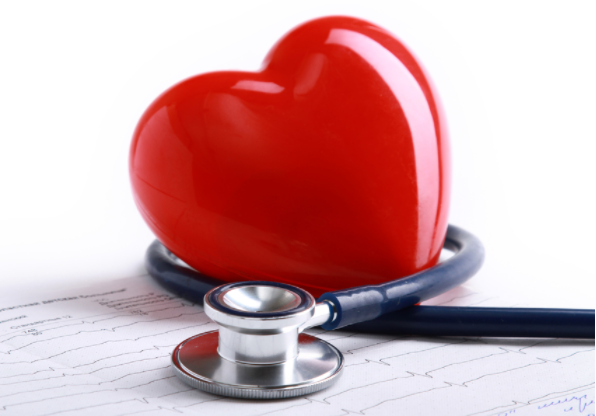

The goal of this project is to predict whether or not a patient has heart disease by building a Classification Tree, we will also use cost complexity pruning to build this classification tree.The datset can be downloaded from __[Machinelearning Repository](https://archive.ics.uci.edu/ml/datasets/heart+disease)__ where you can also find the data description.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix


## Explore the dataset

In [2]:
# Let's read the dataset
hearts = pd.read_csv("processed.cleveland.data", header = None)
hearts.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


Instead of column names we have column numbers, for better handelling of the data let's replace column numbers with column names.

We can find the column names from __[data documentation](https://archive.ics.uci.edu/ml/datasets/heart+disease)__ as follow:

* **age**
* **sex**
* **cp**- chest pain
* **restbp**- resting blood pressure (in mm Hg)
* **chol** - serum cholestrol in mg/dl
* **fbs** - fasting blood sugar
* **restecg** - resting electrocardiographic results
* **thalch** - maximum heart rate achieved
* **exang** - exercise induced angina
* **oldpeak** - ST depression induced by exercise relative to rest
* **slope** - the slope of the peak exercise ST segment
* **ca** - number of major vessels(-) colored by fluoroscopy
* **thal** - short of thalium heart scan
* **hd** - diagnosis of heart disease, the predicted attribute

In [3]:
# Assigning column names
hearts.columns = ["age","sex","cp","restbp","chol","fbs","restecg","thalach","exang",
                   "oldpeak","slope","ca","thal","hd"]
hearts.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


Let's look for missing data.

## Missing Data

In [4]:

hearts.isnull().sum()

age        0
sex        0
cp         0
restbp     0
chol       0
fbs        0
restecg    0
thalach    0
exang      0
oldpeak    0
slope      0
ca         0
thal       0
hd         0
dtype: int64

It looks like there is no missing term, but before making any conclusion we should check the data type for each column.

In [5]:
# Checking data types of each column
hearts.dtypes

age        float64
sex        float64
cp         float64
restbp     float64
chol       float64
fbs        float64
restecg    float64
thalach    float64
exang      float64
oldpeak    float64
slope      float64
ca          object
thal        object
hd           int64
dtype: object

We see that they are almost float64, however two columns **ca** and **thal** have the object type and one column **hd** has int64.
Object data types are used when there are mixtures of things , like mixture of numbers and letters.

So, let's investigate **ca** and **thal**.


In [6]:
#printing unique values in ca
hearts["ca"].unique()

array(['0.0', '3.0', '2.0', '1.0', '?'], dtype=object)

We can see that **ca** contains numbers (0.0, 3.0, 2.0, 1.0) and question marks(?).The question mark represents the missing the data.

Now, let's look at the unique values in **thal**.

In [7]:
#printing the unique values in thal
hearts["thal"].unique()

array(['6.0', '3.0', '7.0', '?'], dtype=object)

Agaain, **thal** also contains question marks, represnting the missing terms.

Now, we have identified missing values, we need to deal with them.

## Dealing with missing data

Since scikit-learn's classification trees do not support dataset with missing values, we need to figure out what to do with these question marks.We can either delete these rows(patients) from the training dataset, or impute values for the missing data.

Let's see the number of rows containing missing values.

In [8]:
hearts.loc[(hearts["ca"] == "?") | (hearts["thal"] == "?")]

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,?,0
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,?,3.0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,?,7.0,1
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,?,2
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,?,7.0,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0


In [9]:
print("Rows with missing terms:",len(hearts.loc[(hearts["ca"] == "?") | (hearts["thal"] == "?")]))

print("Total no of rows:", hearts.shape[0])

Rows with missing terms: 6
Total no of rows: 303


**6** rows out of **303** rows (i.e. **2%**) rows contain missing values.So, **297** is plenty of data to build a classification tree, so we can remove the rows with missing terms.

In [10]:
# Removing the rows with missing values
cleaned_hearts = hearts[(hearts["ca"]!="?") & (hearts["thal"]!="?")]

print("total no. of patients:", cleaned_hearts.shape[0])

total no. of patients: 297


## Splitting the dataset

We will split the dataset into two parts :
1. **X** - contains columns of data that we will use to make classifications
2. **y** - contains the column that we want to predict


In [11]:
# making a new copy of the columns that we are going to use for prediction
X = cleaned_hearts.drop("hd",axis =1).copy()
X.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0


In [12]:
# making a new copy of column that we are going to predict
y = cleaned_hearts["hd"].copy()
y.head()


0    0
1    2
2    1
3    0
4    0
Name: hd, dtype: int64

## Data Formatting
Now, we have split the dataset, we need to take closer look at the variables in X.The __[data documentation](https://archive.ics.uci.edu/ml/datasets/heart+disease)__ tells us what each variable represents :


* **age -float**
* **sex- Category**
   * 0 - female
   * 1 - male
* **cp** - chest pain -**Category**
   * 1 - typical angina
   * 2 - atypical angina
   * 3 - non-anginal pain
   * 4 - asynptomatic
* **restbp** - resting blood pressure - **float**
* **chol** - serum choletrol in mg/dl- **float**
* **fbs** - fasting blood sugar- **category**
   * 0 - >=120 mg/dl
   * 1 - <120 mg/dl
* **restecg** - resting electrocardiographic results - **category**
    * 1 - normal
    * 2- having ST-T wave abnormality
    * 3 - showing probable or definite left ventricular hypertrophy
* **thalach** -  maximum heart rate achieved - **float**
* **exang** - exercise  induced angina - **Category**
   * 0 - no
   * 1 -yes
* **oldpeak** - ST depression induced by exercise realtive to rest - **float**
* **slope** - the slope of the peak exercise relative to rest - **category**
 * 1 - unsloping
 * 2 - flat
 * 3 - downsloping

*  **ca** - number of major vessels (0-3) colored by fluoroscopy - **flaot**
* **thal** - thalium heart scan - **category**
  * 3 - normal (no cold spots)
  * 6 - fixed defect (cold spots during rest and exercise)
  * 7 - reversible defect (when cold spots only appear during exercise)
    
   


In [13]:
# Let's look at the data types in X 
X.dtypes

age        float64
sex        float64
cp         float64
restbp     float64
chol       float64
fbs        float64
restecg    float64
thalach    float64
exang      float64
oldpeak    float64
slope      float64
ca          object
thal        object
dtype: object

So, we can see that **age**, **restbp**,**chol**,**thalch** are float, which is good. All of the other columns , however , need to be inspected to make sure they only ontain reasonable values, and some of them need to change.This is because **scikit learn Decision Trees** support continuous data, like resting blood pressure (**restbp**) and maximum heart rate (**thalach**), they do not support categorical data, like chest pain(**cp**), which contains 4 different categories. Thus, in order to use categorical data with **scikit learn Decision Trees**, we have to convert column of categorical data into multiple columns of binary values.

**Why are we not treating categorical data like continuous?**

consider the column **cp** , we have 4 options:
1. typical angina
2. atypical aangina 
3. non-anginal pain
4. asympotomatic

If we treat these values 1,2,3 and 4 like continuous data then we assume that 4, which means "asympotomatic", is more similar to 3, which means  "non-anginal", than it is to 1 or 2, which are other types of chest pain. Means,  Decision tree more likely to cluster the patients with 4s and 3s together than the patients with 4s and 1s together. In, contrast if we treat these numbers like categorical data, then we treat each one as a seperate category that is no more or less similar to the other categories. Thus, the likelihood of clustering patients with 4s and 3s is the same as clustering 4s with 1s, and that approach is more reasonable.





In [14]:

X["cp"].unique()

array([1., 4., 3., 2.])

In [15]:

columns = ["cp","restecg","slope","thal"]
X_encoded = pd.get_dummies(X, columns=columns)

X_encoded.head()

,age,sex,restbp,chol,fbs,thalach,exang,oldpeak,ca,cp_1.0,...,cp_4.0,restecg_0.0,restecg_1.0,restecg_2.0,slope_1.0,slope_2.0,slope_3.0,thal_3.0,thal_6.0,thal_7.0
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0.0,1,...,0,0,0,1,0,0,1,0,1,0
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,3.0,0,...,1,0,0,1,0,1,0,1,0,0
2,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,2.0,0,...,1,0,0,1,0,1,0,0,0,1
3,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0.0,0,...,0,1,0,0,0,0,1,1,0,0
4,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0.0,0,...,0,0,0,1,1,0,0,1,0,0


Now, let's look into coluns that contain only **0**s and **1**s : **sex**, **fbs**( fasting blood sugar), and **exang**(exercise induced angina). Since, these columns have **2** categories only and contain **0**s and **1**s to begin with, so we do not need to do anything special to them.So we are done with formatting the data for the **Classification tree**. 

In [16]:
y.unique()

array([0, 2, 1, 3, 4], dtype=int64)

As we can see, y contains **5** different levels of heart disease. **0** - no heart disease and  **1-4** are different degrees of heart disease.

We are interested in simple classification whether someone has heart disease or not.
So we can convert all values **> 0** to **1**.


In [17]:
# set each non-zero value in y to 1.
y[y>0] = 1
y.unique()

array([0, 1], dtype=int64)

## Preliminary Classification Tree

Now we simply split the dataset into training and testing sets and build the tree.

In [18]:
# splitting the data into training and testing sets.
X_train , X_test, y_train, y_test = train_test_split(X_encoded, y, random_state =42)

# creating a decision tree and fitting it to train data.
clf_dt = DecisionTreeClassifier(random_state =42)
clf_dt=clf_dt.fit(X_train, y_train)


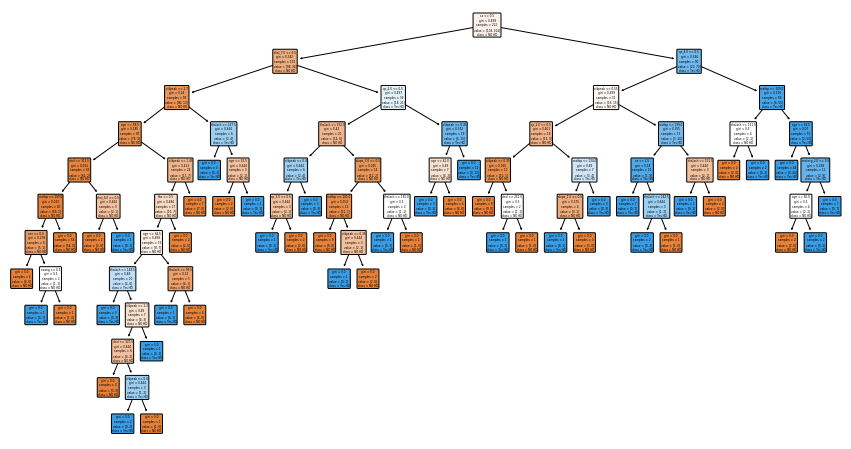

In [19]:
# Let's plot the tree - it's huge!
plt.figure(figsize=(15,8))
plot_tree(clf_dt, filled = True, rounded = True,
         class_names = ["NO HD", "Yes HD"],
         feature_names = X_encoded.columns);

Let's see , how it performs on **test dataset** and draw the **Confusion Matrix**.

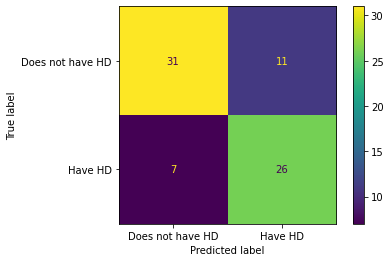

In [20]:
# plotting confusion matrix
plot_confusion_matrix(clf_dt, X_test, y_test, display_labels=["Does not have HD", "Have HD"])

Inthe confusion matrix we can see thatthe **42** people do not have **Heart Disease, 31(74%)** were correctly classified. And of the **33** people that have **Heart Disease, 26(79%)** were correctly clasified.

One thing that might be holding this classification tree back is that it may have **overfit** the training dataset.

So, let's prune the tree. Prunning, should solve the overfitting problem and give the better results. 

## Cost Complexity Prunning

**Decision Trees** are more prone to **overfit** to the **Training dataset** , however **cost complexity pruning**  can simplify the process of finding a samller tree that improoves the accuracy with test dataset.

Pruning the decision tree is all about finding the right value for the prunning parameter, **alpha**.

To find the optimal value of the alpha, we can plot acuuracy of the tree as function of different values of alpha.

First, let's extract the different values of alpha that are availabel for this tree and build  a pruned tree for eah value of alpha.


In [21]:
# determining values of alpha
path = clf_dt.cost_complexity_pruning_path(X_train, y_train)

# extract different values for alpha
ccp_alphas = path.ccp_alphas

# omitting maximum value of alpha 
# because it would prune all leaves, leaving us with only a root instead of a tree.
ccp_alphas = ccp_alphas[:-1]

# creating an array to store decision trees 
clf_dts = []

# creating decision tree for each value of alpha and storing it in the array.
for alpha in ccp_alphas :
    clf_dt = DecisionTreeClassifier(random_state = 0, ccp_alpha = alpha )
    clf_dt.fit(X_train, y_train)
    clf_dts.append(clf_dt)

Now lets graph the accuracies of **training** and **test**   dataset as function of alpha.

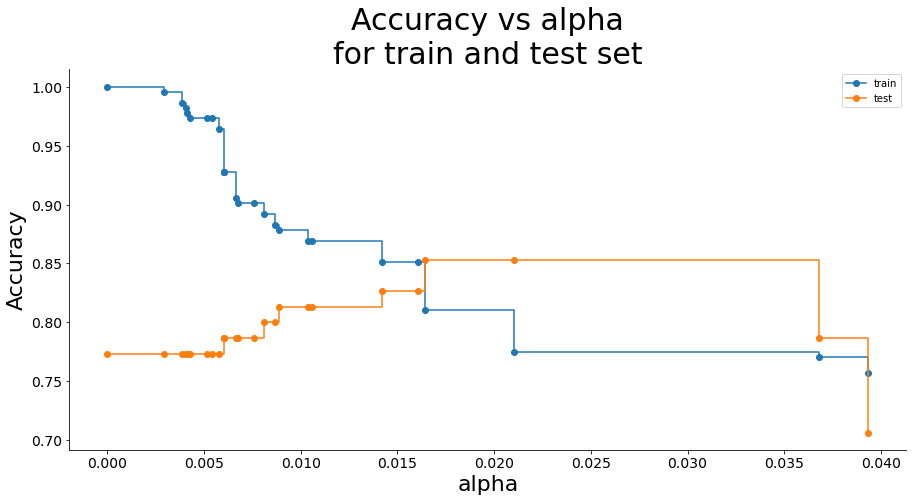

In [22]:
train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

fig, ax = plt.subplots(figsize = (15,7))
ax.plot(ccp_alphas, train_scores,marker = "o",label = "train" ,drawstyle = "steps-post")
ax.plot(ccp_alphas, test_scores,marker ="o",label = "test", drawstyle = "steps-post")
plt.xlabel("alpha", fontsize =22)
plt.ylabel("Accuracy", fontsize =22)
plt.xticks(fontsize =14)
plt.yticks(fontsize =14)
plt.title("Accuracy vs alpha\nfor train and test set", fontsize = 30)
plt.legend()
sns.despine()
plt.show()

We can see that the accuracy of **Testing Dataset** is maximum when **alpha = 0.016**. For further increase in value of alpha, the accuracy of the **Training Dataset** drops off and that suggests we should set ccp_alpha = 0.016.


Now, let's do cross validation to know whether we used best **Training dataset** or not.


## Cross Validation  for finding best value of alpha.

<AxesSubplot:xlabel='tree'>

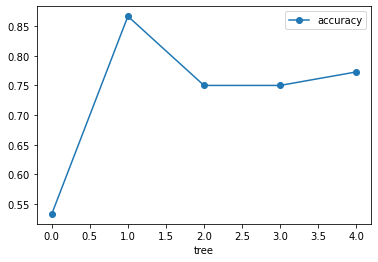

In [23]:
# creating tree with ccp_alpha = 0.016
clf_dt = DecisionTreeClassifier(random_state = 42, ccp_alpha = 0.016)

# use 5-fold cross validation to create 5 different training and testing datasets
# that are then used to train and test the tree
# we used 5-fold because we dont have large dataset

scores = cross_val_score(clf_dt, X_train, y_train, cv =5)
df = pd.DataFrame(data = {'tree' : range(5), 'accuracy':scores})

df.plot(x="tree", y="accuracy", marker="o")


From above graph we can see that , we are getting different acuuracies for different **Training dataset** and **Testing dataset** and for same value of alpha (0.016), which indicates that alpha value is sensitive to the datasets.

<AxesSubplot:xlabel='alpha'>

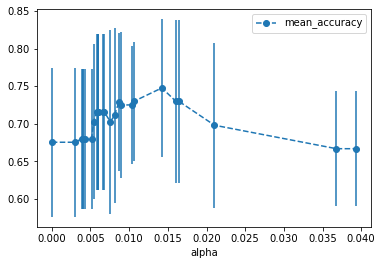

In [24]:
# creating an array to store the results of each fold
alpha_values = []

# for each value of alpha, performing 5-fold cross validation
# storing the mean and standard deviation of the accuracy for each fold  
for alpha in ccp_alphas :
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha = alpha)
    scores = cross_val_score(clf_dt, X_train, y_train,cv =5)
    alpha_values.append([alpha, np.mean(scores), np.std(scores)]) #alpha_values is a list of lists

# plotting the mean and standard deviations of accuracy
# for each value of alpha
alpha_results = pd.DataFrame(alpha_values)
alpha_results.columns = ["alpha","mean_accuracy", "std"]
alpha_results.plot(x="alpha", y="mean_accuracy",yerr="std", marker= "o", linestyle ="--")


We can see that instead of ccp_alpha = 0.016 we need to use alpha value something close to **0.014**.

In [34]:
alpha_results[(alpha_results["alpha"]>0.014) & (alpha_results["alpha"]<0.015)]

,alpha,mean_accuracy,std
20,0.014225,0.747778,0.091395


In [25]:
best_alpha =alpha_results[(alpha_results["alpha"]>0.014) & (alpha_results["alpha"]<0.015)]

# converting best_alpha from a series to float
best_alpha = float(best_alpha["alpha"])

best_alpha

0.014224751066856332

## Building the final classification tree

Now we have the best value for alpha and we can build the final Classification Tree by setting ccp_alpha = best_alpha.

In [26]:
clf_dt_pruned = DecisionTreeClassifier(random_state =42, ccp_alpha = best_alpha)

clf_dt_pruned.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.014224751066856332, random_state=42)

Now, let's draw another confusion matrix to see whether the pruned tree does better job.

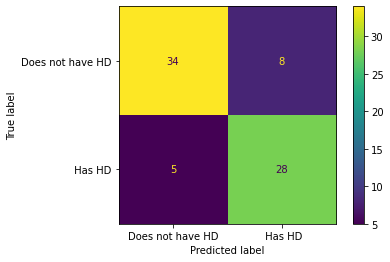

In [27]:
plot_confusion_matrix(clf_dt_pruned, X_test, y_test,
                     display_labels = ["Does not have HD", " Has HD"])

So, we can see that the pruned tree is better at classifying patients than the full sized tree.
Of the **42** people that did not have heart disease,  **34(81%)** were correctly classified this is an imprrovement over the full sized tree, which only correctly classified **31(74%)** of the patients without heart disease. Of the **33** people with heart disease, **28(85%)** were correctly classified.Again, this is an improovement over the full sized tree, which only correctly classified **26 (79%)** of the patients with heart disease 

Let's draw pruned tree.

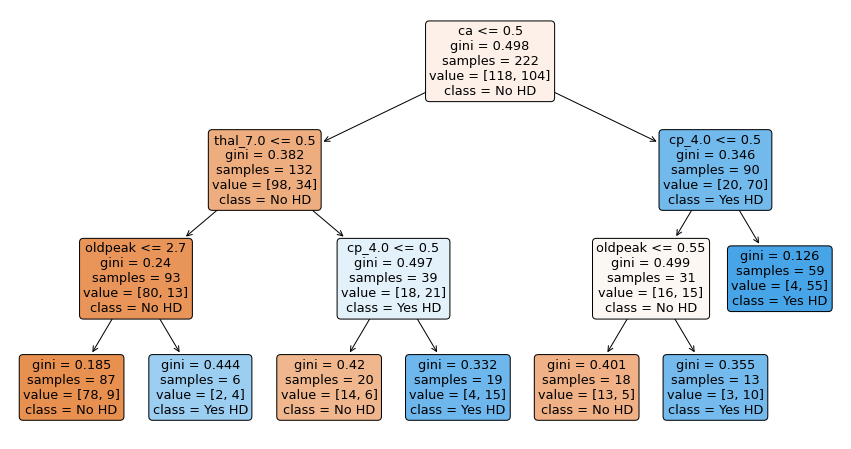

In [28]:
plt.figure(figsize = (15,8))
plot_tree(clf_dt_pruned, filled = True,
         rounded = True,
         class_names = ["No HD", "Yes HD"],
         feature_names = X_encoded.columns);

Let's discuss how to interprete the tree.

## Conclusion